# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **GODAS**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(10)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.878c27058e2e4fc481ee60d2803c05af Dashboard: /services/dask-gateway/clusters/prod.878c27058e2e4fc481ee60d2803c05af/status,Cluster Workers: 10 Cores: 20 Memory: 85.90 GB


In [66]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [4]:
xr.set_options(display_style='text')

In [5]:
path = 'pangeo-tmp/stb2145/GODAS/datasets/'
ds = xr.open_zarr(gcsfs.GCSMap(path + 'ds_wg.zarr'))
coords = xr.open_zarr(gcsfs.GCSMap(path + 'coords_wg.zarr'))
cell_coords = xr.open_zarr(gcsfs.GCSMap(path + 'cell_coords_wg.zarr'))
cell_elements = xr.open_zarr(gcsfs.GCSMap(path + 'cell_elements_wg.zarr'))
surf_flux = xr.open_zarr(gcsfs.GCSMap(path + 'surf_flux.zarr'))
total_tend = xr.open_zarr(gcsfs.GCSMap(path + 'total_tend.zarr'))
vel = xr.open_zarr(gcsfs.GCSMap(path + 'vel.zarr'))

In [6]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
globe = xr.open_zarr(mapping, consolidated=True)

In [57]:
ds.isel(time=slice(0,-2))

<xarray.Dataset>
Dimensions:    (lat: 37, lat_u: 37, level: 40, level_w: 40, lon: 96, lon_u: 96, time: 469)
Coordinates:
  * lat        (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lat_u      (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * level      (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * level_w    (level_w) float32 10.0 20.0 30.0 ... 4.225e+03 4.736e+03
  * lon        (lon) float32 -65.5 -64.5 -63.5 -62.5 ... 26.5 27.5 28.5 29.5
  * lon_u      (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-01-01
Data variables:
    dbss_obil  (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    dbss_obml  (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    dzdt       (time, level_w, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    pottmp     (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    salt       (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    sltfl      (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    sshg       (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    thflx      (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    ucur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    uflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    vcur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    vflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
Attributes:
    Conventions:      COARDS
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    grib_file:        godas.M.198001-12.grb
    history:          Created 2006/12 by Hoop
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    title:            GODAS: Global Ocean Data Assimilation System

In [56]:
ds = ds.isel(time=slice(0,-2))

<xarray.DataArray 'time' (time: 471)>
array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-03-01T00:00:00.000000000', ..., '2019-01-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [29]:
temp = (ds.pottmp - 273.15).load() #K to C
salt = (ds.salt * 1000).load() #kg/kg to g/kg

In [9]:
pref = 2000

In [24]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, salt, temp, pref,
                            output_dtypes=[salt.dtype],
                            dask='parallelized').reset_coords(drop=True).load()

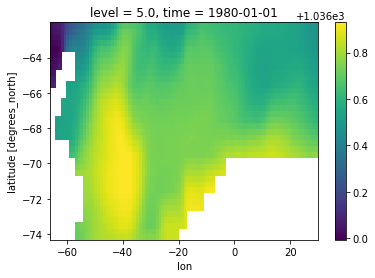

In [26]:
sigma2[0,0].plot()

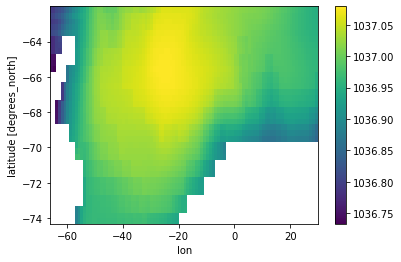

In [27]:
sigma2.mean(dim=['time', 'level']).plot()

(array([ 10.,  25.,  19.,  33., 100., 183., 494., 597., 694., 587.]),
 array([1036.73323119, 1036.76783441, 1036.80243762, 1036.83704084,
        1036.87164406, 1036.90624727, 1036.94085049, 1036.97545371,
        1037.01005692, 1037.04466014, 1037.07926335]),
 <BarContainer object of 10 artists>)

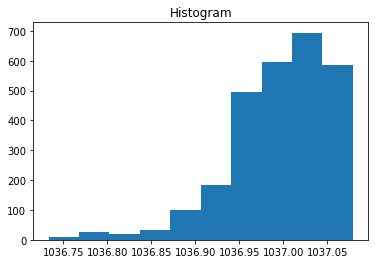

In [28]:
sigma2.mean(dim=['time', 'level']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [42]:
sigma2[:,1:,1:,1:].coords

Coordinates:
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-03-01

In [50]:
delta_sigma[1:,1:,1:].coords

Coordinates:
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

In [51]:
total_time

<xarray.DataArray 'time' ()>
array(1.230768e+09)

In [43]:
cell_coords.cell_volume_wg[:-1, :-1, :]

<xarray.DataArray 'cell_volume_wg' (lon: 95, lat: 36, level: 39)>
dask.array<getitem, shape=(95, 36, 39), dtype=float32, chunksize=(48, 36, 39), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

In [45]:
delta_sigma = sigma2.isel(time=-3) - sigma2.isel(time=0)
total_time = (sigma2.time[-3] - sigma2.time[0]).astype('f8')*1e-9

In [52]:
vol = cell_coords.cell_volume_wg[:-1, :-1, :]
((delta_sigma[1:,1:,1:] * vol).sum(dim=['lat', 'lon'])/ total_time).plot(y='level', yincrease=False, color='y')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['lat', 'lon']).mean(dim='time').plot(y='level', yincrease=False, color='k')

ValueError: 'YC' not found in array dimensions ('level', 'lat', 'lon')

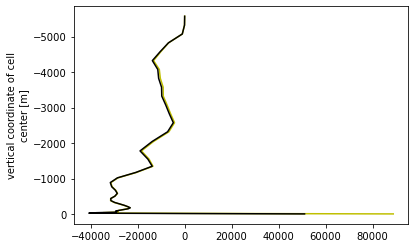

In [18]:
vol = cell_coords.cell_volume_wg[:-1, :-1, :]
((delta_sigma[1:,1:,1:] * vol).sum(dim=['YC', 'XC'])/ total_time).plot(y='Z', yincrease=False, color='y')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k')

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>